# Using Regressional Analysis to better understand the ADNI Database:

#### Read the database and select for each person the datapoint with their first MRI Scan:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'font.family': 'DejaVu Sans'})
sns.set_theme(style="darkgrid")

data = pd.read_csv("DATA/ADNI_dataset.csv", low_memory=False) # Need the low_memory or dtypes warning
data.replace({'Sex':{'F':1, 'M':0}}, inplace=True)

# The columns that interest us are the sex and age related, the ROIs, as well as the genetic data:
columns_of_interest = ['PTID',
                       'MRID',
                       'Date',
                       'Age', 
                       'Sex',
                       'DLICV_baseline',
                       'APOE4_Alleles',
                       'APOE_Genotype',
                       'Diagnosis_nearest_2.0']
c = list(data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]

columns_of_interest += MRI_columns + genetic_columns
data_of_interest = data[columns_of_interest]


# Need the dropna because some first PTIDs have no MRI
data_of_interest.dropna(subset=['MUSE_Volume_4', 'DLICV_baseline','Diagnosis_nearest_2.0'], inplace=True)
data_of_interest.sort_values(by=['PTID', 'Age'])
unique = data_of_interest.drop_duplicates(subset=['PTID'], keep='first')
unique_data_without_LR = unique.copy()

unique['Diagnosis_nearest_2.0'] = unique['Diagnosis_nearest_2.0'].astype('category')
unique['Diagnosis_nearest_2.0_cat'] = unique['Diagnosis_nearest_2.0'].cat.codes
print(unique.shape)
unique.head(10)

(1567, 209)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,1873.124153,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,2131.516933,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,2366.717680,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,5124.734093,...,0,0,0,1,1,0,0,0,2,1
36,002_S_0685,002_S_0685_2006-07-06,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,2941.520445,...,1,1,1,0,0,0,0,0,0,0
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,966.095170,...,0,0,0,1,1,0,0,0,1,2
64,002_S_0816,002_S_0816_2006-08-30,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1427.160586,...,0,0,0,0,1,0,0,0,2,1
69,002_S_0938,002_S_0938_2006-10-05,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1931.131939,...,0,1,1,0,1,0,0,0,0,1
74,002_S_0954,002_S_0954_2006-10-10,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,707.696352,...,2,1,1,0,1,0,0,0,1,2
81,002_S_0955,002_S_0955_2006-10-11,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,2681.014413,...,1,0,0,0,1,0,0,0,1,1


In [2]:
unique.describe()

,Age,Sex,DLICV_baseline,APOE4_Alleles,MUSE_Volume_4,MUSE_Volume_11,MUSE_Volume_23,MUSE_Volume_30,MUSE_Volume_31,MUSE_Volume_32,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
count,1567.000000,1567.000000,1.567000e+03,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,73.813930,0.435227,1.428763e+06,0.572431,1760.170636,1747.376593,354.519350,390.800399,934.421522,982.750502,...,0.343331,0.355456,0.360562,0.167837,0.590938,0.176133,0.181876,0.178685,0.569241,1.214422
std,7.149737,0.495945,1.438706e+05,0.667399,777.161321,579.871305,65.326396,70.733256,162.643803,167.684822,...,0.533242,0.546094,0.550909,0.380612,0.642667,0.406985,0.411493,0.407440,0.666780,0.870238
min,54.273973,0.000000,1.057343e+06,0.000000,279.599289,649.198349,188.787377,219.599442,428.399974,465.599972,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.256164,0.000000,1.323742e+06,0.000000,1181.114188,1327.802492,310.077739,345.937011,832.798916,869.998868,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,73.967123,0.000000,1.423724e+06,0.000000,1636.881290,1643.708008,352.265346,388.125000,939.599944,984.375000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,78.953425,1.000000,1.527860e+06,1.000000,2230.312500,2039.288200,394.799976,432.211664,1041.290250,1093.455436,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000
max,91.306849,1.000000,1.905572e+06,2.000000,5464.820847,4804.855004,621.341431,661.875000,1616.396692,1691.996537,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


#### Performing Regressional Analysis to uncover the relation between age, sex and ROIs:

In [3]:
age_mask =      (unique['Age']>=65)   &   (unique['Age']<=85)
CN_mask =       (unique['Age']>=65)   &   (unique['Age']<=85)   &   (unique['Diagnosis_nearest_2.0'] == 'CN') 
MCI_mask =      (unique['Age']>=65)   &   (unique['Age']<=85)   &   (unique['Diagnosis_nearest_2.0'] == 'MCI')
AD_mask =       (unique['Age']>=65)   &   (unique['Age']<=85)   &   (unique['Diagnosis_nearest_2.0'] == 'Dementia')

-------------------------------------------------------------- ROI  MUSE_Volume_48  --------------------------------------------------------------
Coefficients: 			 [[-2.52497980e+01 -2.40189666e+01  1.64495355e-03]] 

Intercept: 			 [3073.48740993] 

Mean squared error: 		 277534.27 

Coefficient of determination: 	 -0.04 



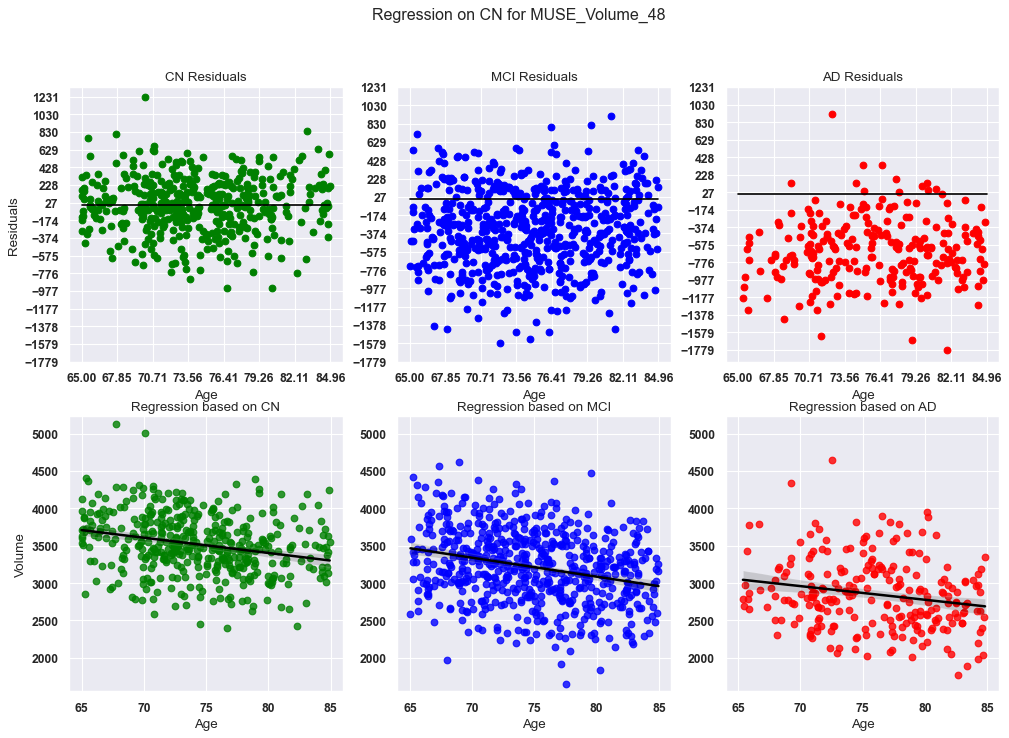

In [4]:
X = unique[['Age','Sex','DLICV_baseline']].values
Y = unique[['MUSE_Volume_48']].values

regr = LinearRegression().fit(X[CN_mask],Y[CN_mask])

Y_pred = Y.copy()
Y_pred = regr.predict(X)
Y_resid = Y - Y_pred

print("-------------------------------------------------------------- ROI ", "MUSE_Volume_48",  " --------------------------------------------------------------")
# The coefficients
print("Coefficients: \t\t\t", regr.coef_, "\n")
# The intercept
print("Intercept: \t\t\t", regr.intercept_, "\n")
# The mean squared error
print("Mean squared error: \t\t %.2f" % mean_squared_error(Y[age_mask], Y_pred[age_mask]), "\n")
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: \t %.2f" % r2_score(Y[age_mask], Y_pred[age_mask]), "\n")

fig, ax_arr = plt.subplots(nrows=2,ncols=3,figsize=(15,10), dpi=80)

ax_arr[0,0].scatter(X[CN_mask][:,0], Y_resid[CN_mask], color="green")
ax_arr[0,1].scatter(X[MCI_mask][:,0], Y_resid[MCI_mask], color="blue")
ax_arr[0,2].scatter(X[AD_mask][:,0], Y_resid[AD_mask], color="red")

x = np.linspace(   min(X[age_mask][:,0]), max(X[age_mask][:,0]), num=len(X[CN_mask][:,0])   )
y = y = 0 * x
ax_arr[0,0].plot(x, y, color='black')
ax_arr[0,1].plot(x, y, color='black')
ax_arr[0,2].plot(x, y, color='black')

ax_arr[0,0].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
ax_arr[0,0].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))
ax_arr[0,1].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
ax_arr[0,1].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))
ax_arr[0,2].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
ax_arr[0,2].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))


ax_arr[0,0].set_title("CN Residuals")
ax_arr[0,0].set_xlabel('Age')
ax_arr[0,0].set_ylabel('Residuals')
ax_arr[0,1].set_title("MCI Residuals")
ax_arr[0,1].set_xlabel('Age')
ax_arr[0,2].set_title("AD Residuals")
ax_arr[0,2].set_xlabel('Age')

sns.regplot(x=X[CN_mask][:,0], y=Y[CN_mask], 
            color = 'green', 
            scatter=True, 
            ax = ax_arr[1,0],
            line_kws={'color':"black"})
sns.regplot(x=X[MCI_mask][:,0], y=Y[MCI_mask], 
            color = 'blue', 
            scatter=True, 
            ax = ax_arr[1,1],
            line_kws={'color':"black"})
sns.regplot(x=X[AD_mask][:,0], y=Y[AD_mask], 
            color = 'red', 
            scatter=True, 
            ax = ax_arr[1,2],
            line_kws={'color':"black"})

ax_arr[1,0].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
ax_arr[1,1].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
ax_arr[1,2].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
ax_arr[1,0].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)
ax_arr[1,1].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)
ax_arr[1,2].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)

ax_arr[1,0].set_title("Regression based on CN")
ax_arr[1,0].set_xlabel('Age')
ax_arr[1,0].set_ylabel('Volume')
ax_arr[1,1].set_title("Regression based on MCI")
ax_arr[1,1].set_xlabel('Age')
ax_arr[1,2].set_title("Regression based on AD")
ax_arr[1,2].set_xlabel('Age')

fig.suptitle("Regression on CN for MUSE_Volume_48")
plt.show()
print("\n\n")

#### Perform Regression for each of the ROIs, find residuals, and replace the ROI values with those:

In [6]:
def Find_residuals(df, ROI_name, pp=False, min_age=65, max_age=85):
    X = df[['Age','Sex','DLICV_baseline']].values
    Y = df[[ROI_name]].values

    age_mask =      (df['Age']>=min_age)   &   (df['Age']<=max_age)
    CN_mask =       (df['Age']>=min_age)   &   (df['Age']<=max_age)   &   (df['Diagnosis_nearest_2.0'] == 'CN') 
    MCI_mask =      (df['Age']>=min_age)   &   (df['Age']<=max_age)   &   (df['Diagnosis_nearest_2.0'] == 'MCI')
    AD_mask =       (df['Age']>=min_age)   &   (df['Age']<=max_age)   &   (df['Diagnosis_nearest_2.0'] == 'Dementia')

    regr = LinearRegression().fit(X[CN_mask],Y[CN_mask])

    Y_pred = Y.copy()
    Y_pred = regr.predict(X)
    Y_resid = Y - Y_pred
    
    if not pp:
        return Y_resid


    print("-------------------------------------------------------------- ROI ", ROI_name,  " --------------------------------------------------------------")
    # The coefficients
    print("Coefficients: \t\t\t", regr.coef_, "\n")
    # The intercept
    print("Intercept: \t\t\t", regr.intercept_, "\n")
    # The mean squared error
    print("Mean squared error: \t\t %.2f" % mean_squared_error(Y[age_mask], Y_pred[age_mask]), "\n")
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: \t %.2f" % r2_score(Y[age_mask], Y_pred[age_mask]), "\n")

    fig, ax_arr = plt.subplots(nrows=2,ncols=3,figsize=(15,10), dpi=80)

    ax_arr[0,0].scatter(X[CN_mask][:,0], Y_resid[CN_mask], color="green")
    ax_arr[0,1].scatter(X[MCI_mask][:,0], Y_resid[MCI_mask], color="blue")
    ax_arr[0,2].scatter(X[AD_mask][:,0], Y_resid[AD_mask], color="red")

    x = np.linspace(   min(X[age_mask][:,0]), max(X[age_mask][:,0]), num=len(X[CN_mask][:,0])   )
    y = y = 0 * x
    ax_arr[0,0].plot(x, y, color='black')
    ax_arr[0,1].plot(x, y, color='black')
    ax_arr[0,2].plot(x, y, color='black')

    ax_arr[0,0].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
    ax_arr[0,0].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))
    ax_arr[0,1].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
    ax_arr[0,1].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))
    ax_arr[0,2].set_xticks(np.linspace(min(X[age_mask][:,0]), max(X[age_mask][:,0]), num = 8))
    ax_arr[0,2].set_yticks(np.linspace(min(Y_resid[age_mask]), max(Y_resid[age_mask]), num = 16))


    ax_arr[0,0].set_title("CN Residual Error")
    ax_arr[0,0].set_xlabel('Age')
    ax_arr[0,0].set_ylabel('Residual Error')
    ax_arr[0,1].set_title("MCI Residual Error")
    ax_arr[0,1].set_xlabel('Age')
    ax_arr[0,2].set_title("AD Residual Error")
    ax_arr[0,2].set_xlabel('Age')

    sns.regplot(x=X[CN_mask][:,0], y=Y[CN_mask], 
                color = 'green', 
                scatter=True, 
                ax = ax_arr[1,0],
                line_kws={'color':"black"})
    sns.regplot(x=X[MCI_mask][:,0], y=Y[MCI_mask], 
                color = 'blue', 
                scatter=True, 
                ax = ax_arr[1,1],
                line_kws={'color':"black"})
    sns.regplot(x=X[AD_mask][:,0], y=Y[AD_mask], 
                color = 'red', 
                scatter=True, 
                ax = ax_arr[1,2],
                line_kws={'color':"black"})

    ax_arr[1,0].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
    ax_arr[1,1].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
    ax_arr[1,2].set_xlim(xmin=min(X[age_mask][:,0])-1, xmax=max(X[age_mask][:,0])+1)
    ax_arr[1,0].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)
    ax_arr[1,1].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)
    ax_arr[1,2].set_ylim(ymin=min(Y[age_mask])-100, ymax=max(Y[age_mask])+100)

    ax_arr[1,0].set_title("Regression based on CN")
    ax_arr[1,0].set_xlabel('Age')
    ax_arr[1,0].set_ylabel('Volume')
    ax_arr[1,1].set_title("Regression based on MCI")
    ax_arr[1,1].set_xlabel('Age')
    ax_arr[1,2].set_title("Regression based on AD")
    ax_arr[1,2].set_xlabel('Age')

    fig.suptitle("Regression on CN for " + ROI_name)
    plt.show()
    print("\n\n")

    return Y_resid

In [7]:
for roi in MRI_columns:
    y_res = Find_residuals(unique, roi)
    unique[roi] = y_res

In [8]:
unique.head(10)

,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,0,0,0,1,1,0,0,0,2,1
36,002_S_0685,002_S_0685_2006-07-06,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,766.918798,...,1,1,1,0,0,0,0,0,0,0
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,0,0,0,1,1,0,0,0,1,2
64,002_S_0816,002_S_0816_2006-08-30,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,-126.260419,...,0,0,0,0,1,0,0,0,2,1
69,002_S_0938,002_S_0938_2006-10-05,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,200.102369,...,0,1,1,0,1,0,0,0,0,1
74,002_S_0954,002_S_0954_2006-10-10,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,-60.539913,...,2,1,1,0,1,0,0,0,1,2
81,002_S_0955,002_S_0955_2006-10-11,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1058.028132,...,1,0,0,0,1,0,0,0,1,1


In [9]:
print(unique.shape)
print(unique[age_mask].shape)

(1567, 209)
(1302, 209)


#### Compare data before and after Linear Regression using Histograms:

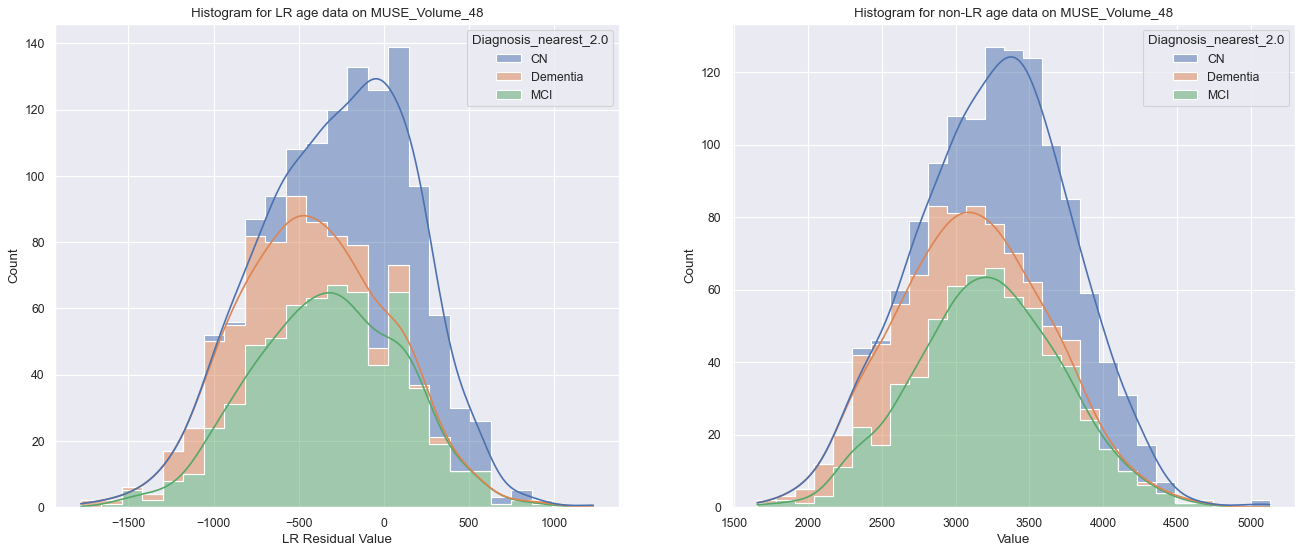

In [10]:
# For example, using ROI for Hippocampus:
roi_name = 'MUSE_Volume_48'

# Male = 0, Female = 1
fig, ax_arr = plt.subplots(nrows=1,ncols=2,figsize=(20,8), dpi=80)
sns.histplot(data=unique[age_mask], x=roi_name, hue='Diagnosis_nearest_2.0', element='step', kde=True, multiple="stack", ax=ax_arr[0])
sns.histplot(data=unique_data_without_LR[age_mask], x=roi_name, hue='Diagnosis_nearest_2.0', element='step', kde=True, multiple="stack", ax=ax_arr[1])

ax_arr[0].set_title("Histogram for LR age data on "+roi_name)
ax_arr[0].set_xlabel('LR Residual Value')
ax_arr[1].set_title("Histogram for non-LR age data on "+roi_name)
ax_arr[1].set_xlabel('Value')

plt.show()

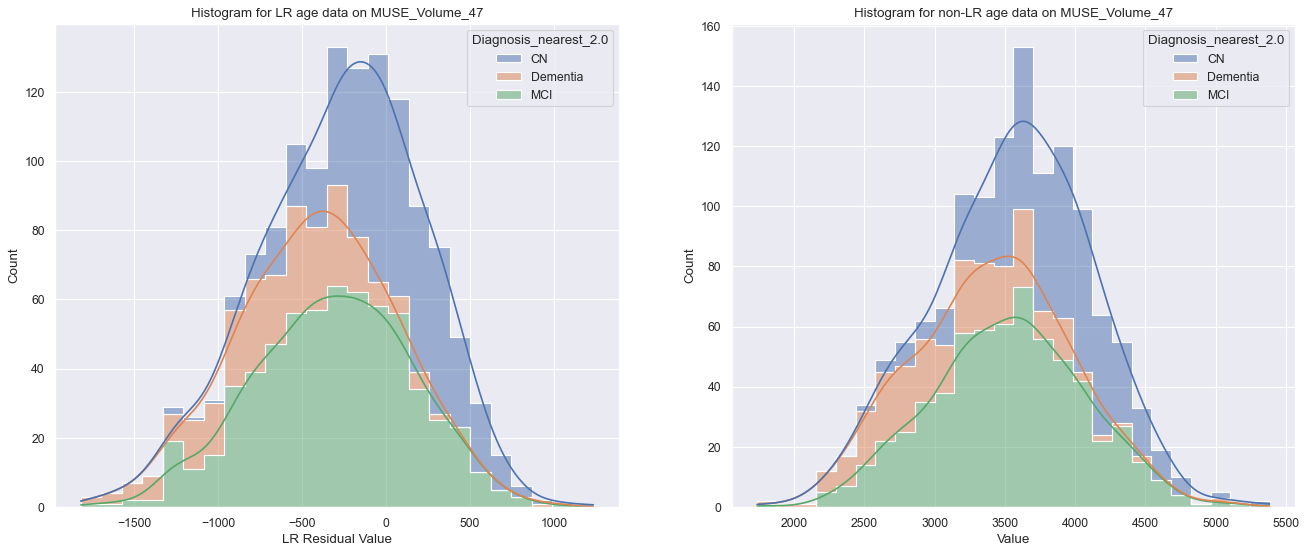

In [11]:
# For example, using ROI for Hippocampus:
roi_name = 'MUSE_Volume_47'

# Male = 0, Female = 1
fig, ax_arr = plt.subplots(nrows=1,ncols=2,figsize=(20,8), dpi=80)
sns.histplot(data=unique[age_mask], x=roi_name, hue='Diagnosis_nearest_2.0', element='step', kde=True, multiple="stack", ax=ax_arr[0])
sns.histplot(data=unique_data_without_LR[age_mask], x=roi_name, hue='Diagnosis_nearest_2.0', element='step', kde=True, multiple="stack", ax=ax_arr[1])

ax_arr[0].set_title("Histogram for LR age data on "+roi_name)
ax_arr[0].set_xlabel('LR Residual Value')
ax_arr[1].set_title("Histogram for non-LR age data on "+roi_name)
ax_arr[1].set_xlabel('Value')

plt.show()

#### Save only the ages that interest us:

In [12]:
unique[age_mask].to_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
unique[age_mask].to_csv("./DATA/Linearly_Transformed_Unique_Dataset.csv")
